In [12]:
from config import *
from utils import convert_dtypes, ModelTrainer, bootstrap_mean_difference
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from lightgbm import LGBMClassifier

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('bmh')

In [13]:
data_for_train = pd.read_csv(cfg.paths.train_sample).pipe(convert_dtypes)[cfg.training.short_list + ['SK_ID_CURR', 'SAMPLE', 'TARGET']]
train = data_for_train[data_for_train['SAMPLE'] == 'TRAIN'].drop(columns=['SAMPLE'])
oos = data_for_train[data_for_train['SAMPLE'] == 'OOS'].drop(columns=['SAMPLE'])
test = pd.read_csv(cfg.paths.test_sample).pipe(convert_dtypes)[cfg.training.short_list + ['SK_ID_CURR']]

X_train, y_train = train.drop(columns=['TARGET']), train['TARGET']
X_oos, y_oos = oos.drop(columns=['TARGET']), oos['TARGET']

del data_for_train, train, oos

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)

In [15]:
model = LGBMClassifier(
    verbosity=-1, 
    importance_type='gain', 
    random_state=cfg.seed, 
    **cfg.training.model_params
)

In [5]:
trainer = ModelTrainer()
trainer.train(model, X_train, y_train, X_oos, y_oos, test, cv)

Training has been completed successfully


In [6]:
trainer.results['metrics']

,fold,train_roc_auc,valid_roc_auc,oos_roc_auc,train_pr_auc,valid_pr_auc,oos_pr_auc
0,0,0.828953,0.782698,0.792541,0.358129,0.279409,0.276057
1,1,0.829627,0.778910,0.792957,0.359738,0.267379,0.276712
2,2,0.828314,0.786428,0.793261,0.359339,0.277385,0.276936
3,3,0.828053,0.789358,0.793708,0.355891,0.284438,0.277025
4,4,0.828323,0.785927,0.793604,0.358716,0.281485,0.275928
5,MEAN,0.828654,0.784664,0.793214,0.358363,0.278019,0.276532
6,STD,0.000570,0.003570,0.000428,0.001352,0.005810,0.000454
7,OVERALL,0.828655,0.784641,0.795323,0.358307,0.277500,0.279727


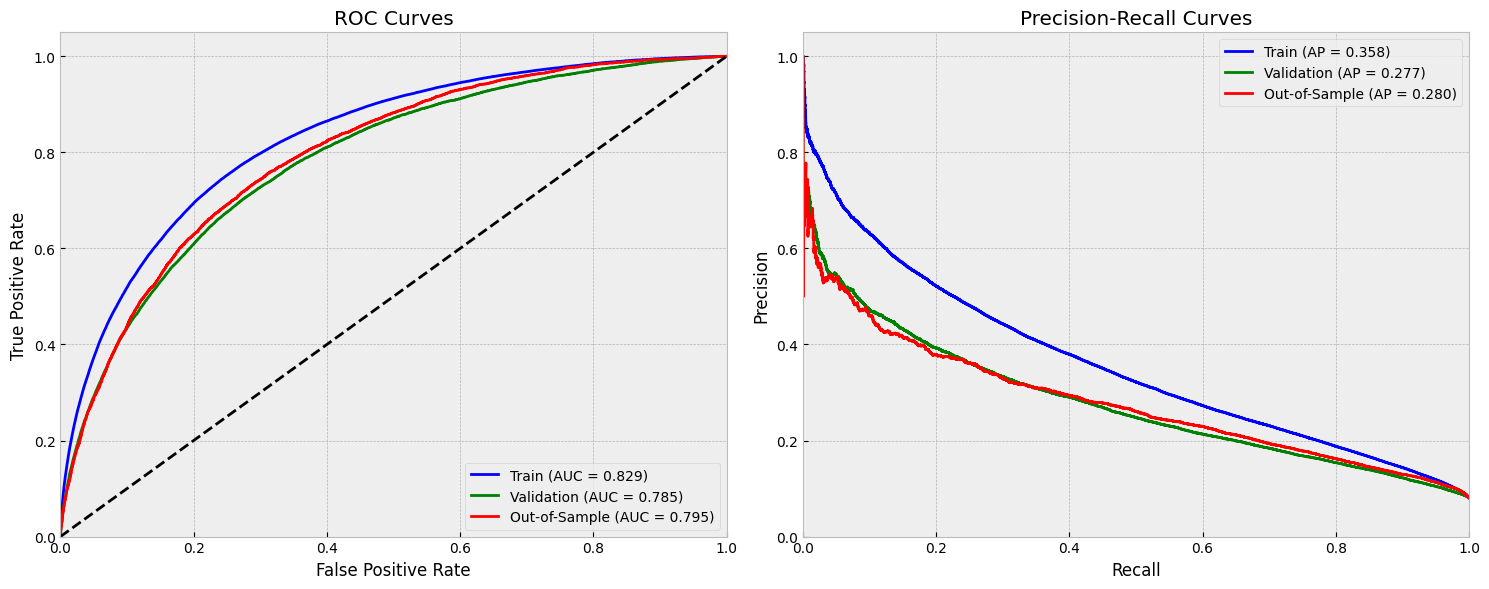

In [7]:
trainer.plot_eval_metrics()

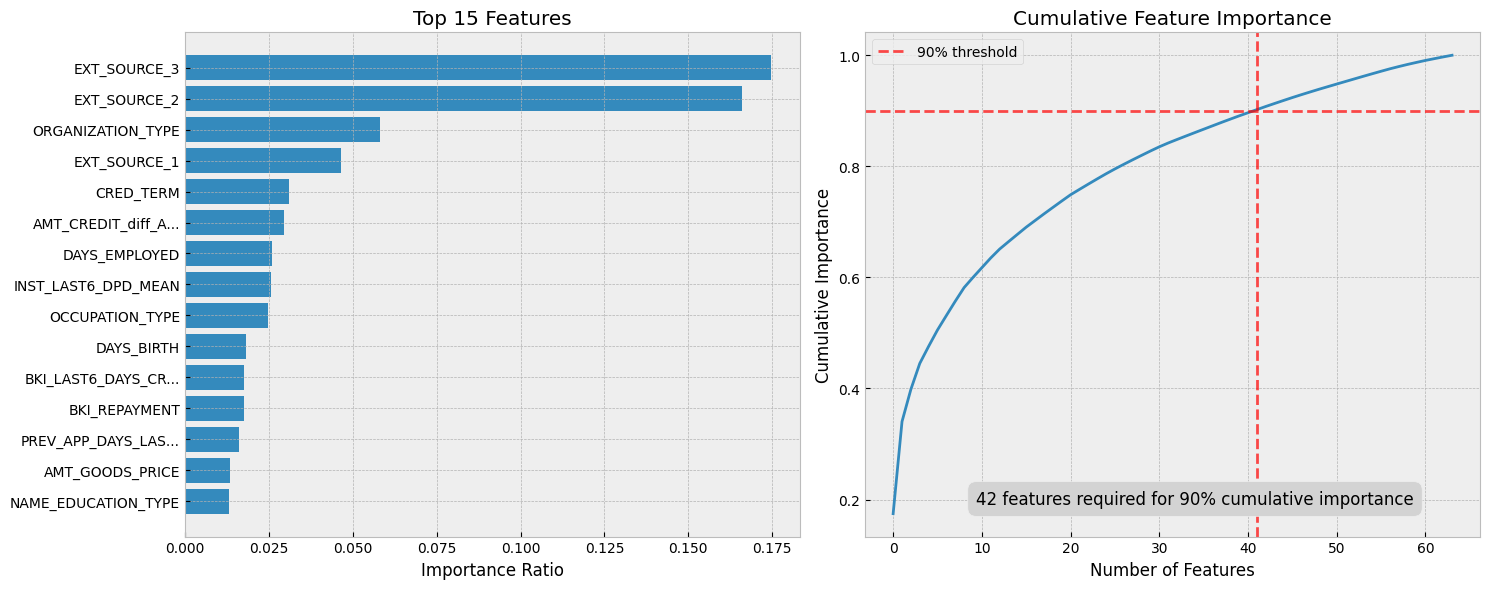

In [8]:
trainer.plot_feature_importances()

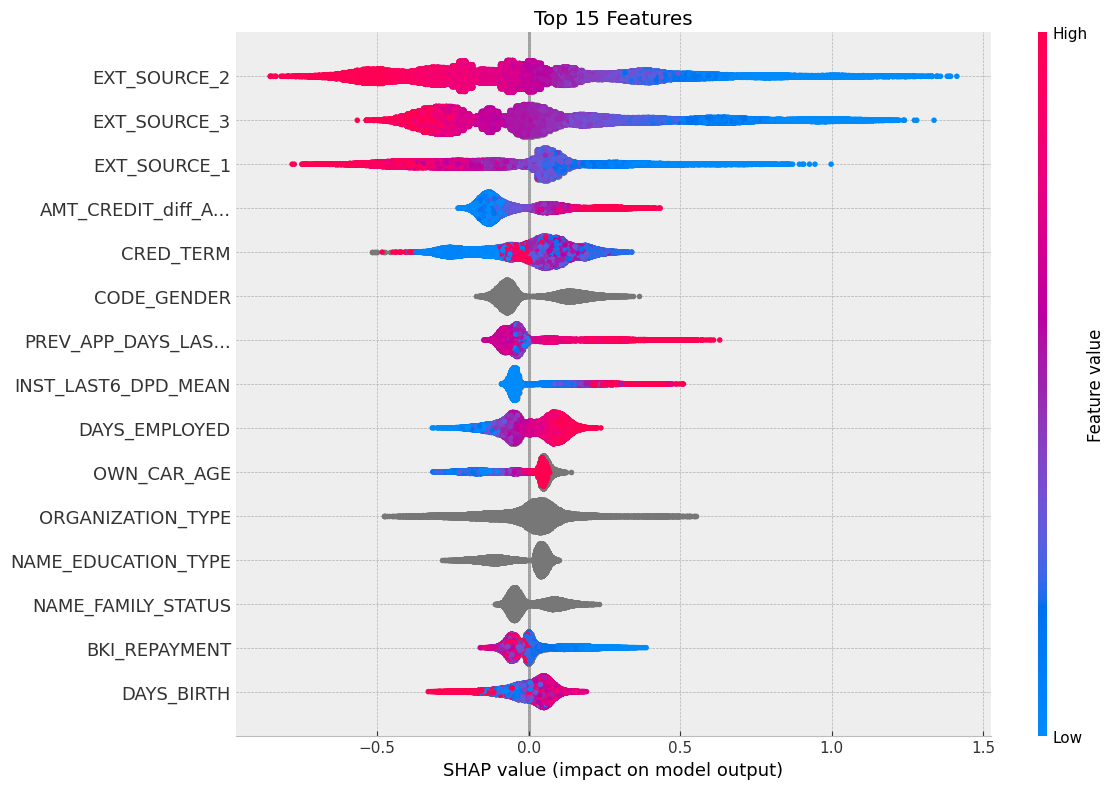

In [9]:
trainer.plot_shap_values(X_oos)

In [ ]:
#trainer.save_predictions('./submissions/shortlist_n250.csv')

In [16]:
model.fit(X_train, y_train)
proba = model.predict_proba(X_oos)[:, 1]

In [17]:
brier_score = brier_score_loss(y_oos, proba, pos_label=1)

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_oos, 
    proba, 
    n_bins=5,
    strategy='uniform'
)

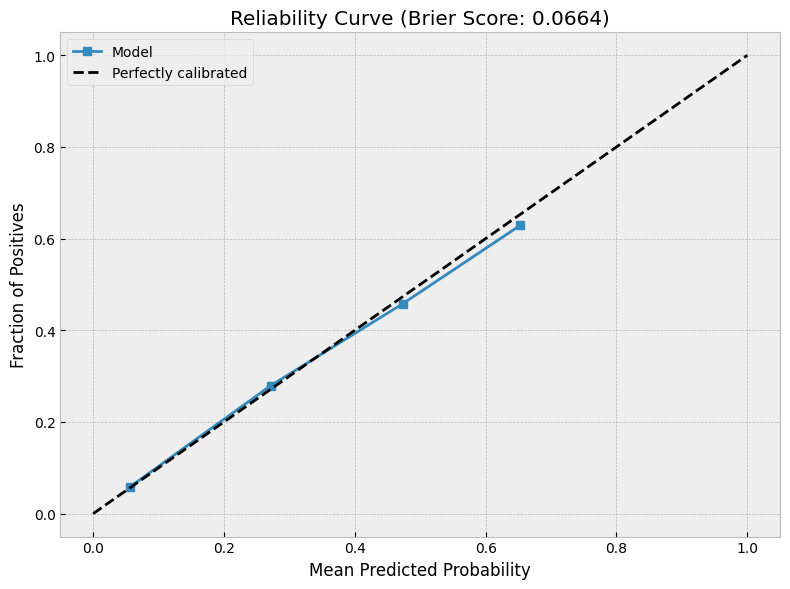

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")


plt.title(f"Reliability Curve (Brier Score: {brier_score:.4f})")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
scored_data = pd.read_csv(cfg.paths.train_sample_scored)

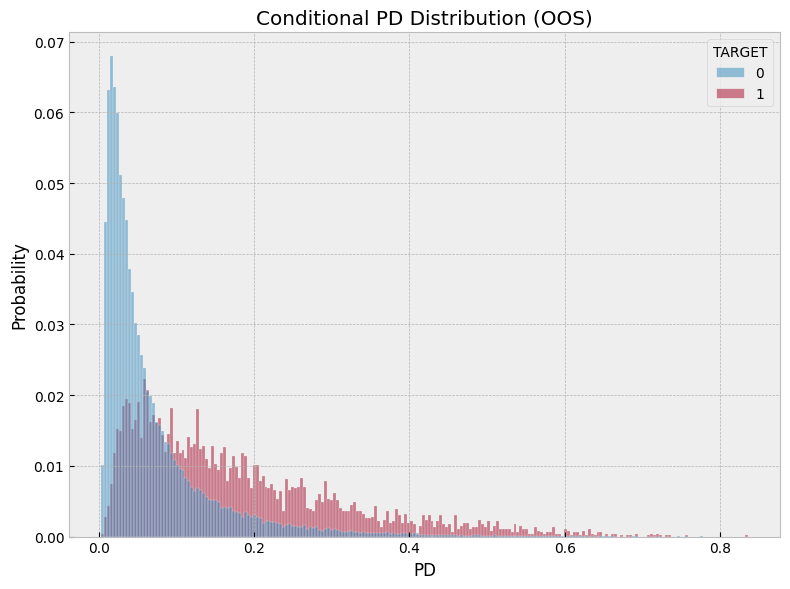

In [ ]:
plt.figure(figsize=(8, 6))

sns.histplot(data=scored_data.query("SAMPLE == 'OOS'"), x='PD', hue='TARGET', stat='probability', common_norm=False)

plt.title("Conditional PD Distribution (OOS)")

plt.tight_layout()
plt.show()

In [ ]:
results = {}
for sample_name in ['ALL', 'TRAIN', 'OOS']:
    if sample_name == 'ALL':
        sample_data = scored_data
    else:
        sample_data = scored_data[scored_data['SAMPLE'] == sample_name]
    
    results[sample_name] = bootstrap_mean_difference(sample_data)

results_df = pd.DataFrame(results).T

In [51]:
display(results_df)

,observed_diff,ci_lower,ci_upper,significant,n_bootstraps,confidence_level
ALL,-0.000468,-0.001463,0.000534,False,10000,95
TRAIN,0.000021,-0.001096,0.00115,False,10000,95
OOS,-0.0026,-0.004994,-0.000218,True,10000,95


In [102]:
results = {}
for sample_name in ['ALL', 'TRAIN', 'OOS']:
    if sample_name == 'ALL':
        sample_data = scored_data
    else:
        sample_data = scored_data[scored_data['SAMPLE'] == sample_name]
    
    results[sample_name] = bootstrap_mean_difference(sample_data, ci=99)

results_df = pd.DataFrame(results).T

In [103]:
display(results_df)

,observed_diff,ci_lower,ci_upper,significant,n_bootstraps,confidence_level
ALL,-0.000468,-0.001773,0.00089,False,10000,99
TRAIN,0.000021,-0.001449,0.001478,False,10000,99
OOS,-0.0026,-0.005796,0.000621,False,10000,99


In [25]:
scored_data['DAYS_BIRTH_BIN'] = pd.qcut(scored_data['DAYS_BIRTH'], q=3, labels=['SENIOR', 'ADULT', 'YOUNG ADULT'])
scored_data['CRED_TERM'] = np.floor(scored_data['CRED_TERM'])

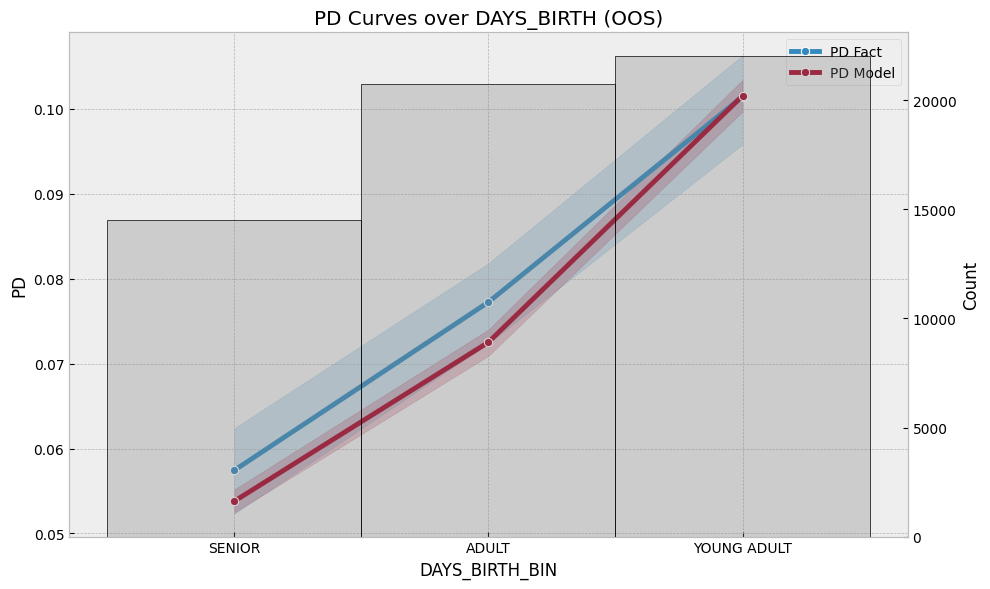

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=scored_data.query("SAMPLE == 'OOS'"), x='DAYS_BIRTH_BIN', y='TARGET', marker='o', lw=3.5, errorbar=('ci', 99), label='PD Fact', ax=ax1)
sns.lineplot(data=scored_data.query("SAMPLE == 'OOS'"), x='DAYS_BIRTH_BIN', y='PD', marker='o', lw=3.5, errorbar=('ci', 99), label='PD Model', ax=ax1)

plt.title('PD Curves over DAYS_BIRTH (OOS)')
plt.ylabel("PD")

ax2 = ax1.twinx()
sns.histplot(data=scored_data.query("SAMPLE == 'OOS'"), x='DAYS_BIRTH_BIN', discrete=True, color='gray', edgecolor='black', alpha=0.3)
ax2.grid(False)

plt.tight_layout()
plt.show()

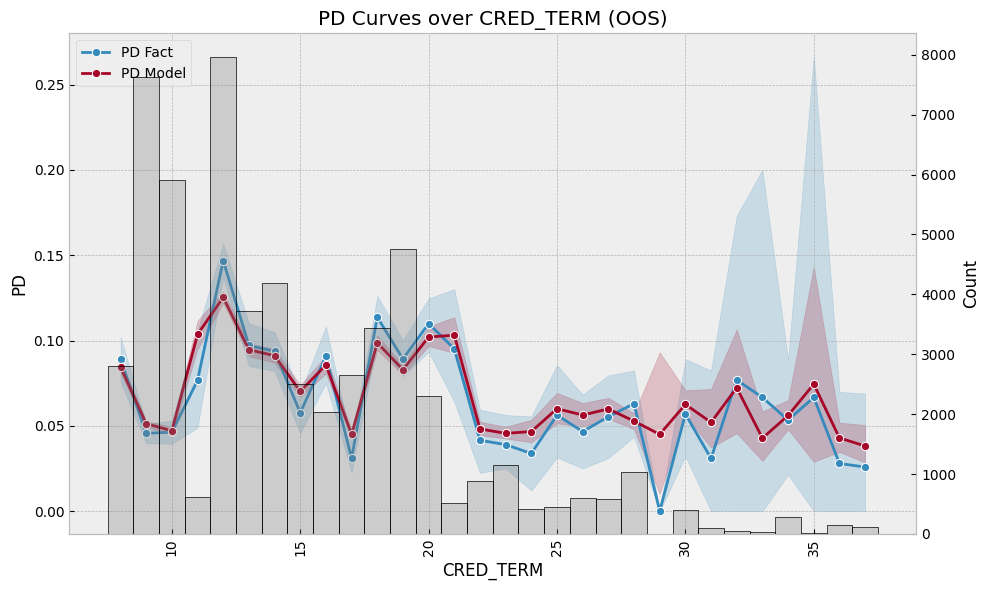

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=scored_data.query("SAMPLE == 'OOS' and CRED_TERM < 40"), x='CRED_TERM', y='TARGET', marker='o', errorbar=('ci', 99), label='PD Fact', ax=ax1)
sns.lineplot(data=scored_data.query("SAMPLE == 'OOS' and CRED_TERM < 40"), x='CRED_TERM', y='PD', marker='o', errorbar=('ci', 99), label='PD Model', ax=ax1)

plt.title('PD Curves over CRED_TERM (OOS)')
plt.ylabel("PD")
plt.xticks(rotation=90)

ax2 = ax1.twinx()
sns.histplot(data=scored_data.query("SAMPLE == 'OOS' and CRED_TERM < 40"), x='CRED_TERM', discrete=True, color='gray', edgecolor='black', alpha=0.3)
ax2.grid(False)

plt.tight_layout()
plt.show()